In [2]:
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import skew

C:\Users\dusti\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
def mean_squared_error_(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions) ** 0.5
RMSE = make_scorer(mean_squared_error_, greater_is_better=False) 

In [5]:
def create_submission(prediction,score):
    now = datetime.datetime.now()
    sub_file = 'submission_'+str(score)+'_'+str(now.strftime("%Y-%m-%d-%H-%M"))+'.csv'
    print ('Creating submission: ', sub_file)
    pd.DataFrame({'Id': test['Id'].values, 'SalePrice': prediction}).to_csv(sub_file, index=False)

In [6]:
def data_preprocess(train,test):
    outlier_idx = [4,11,13,20,46,66,70,167,178,185,199, 224,261, 309,313,318, 349,412,423,440,454,477,478, 523,540, 581,588,595,654,688, 691, 774, 798, 875, 898,926,970,987,1027,1109, 1169,1182,1239, 1256,1298,1324,1353,1359,1405,1442,1447]
    train.drop(train.index[outlier_idx],inplace=True)
    all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                          test.loc[:,'MSSubClass':'SaleCondition']))

In [7]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                          test.loc[:,'MSSubClass':'SaleCondition']))

In [8]:
to_delete = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature']

In [9]:
all_data = all_data.drop(to_delete,axis=1)

In [10]:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [11]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index


In [12]:
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness

In [13]:
skewed_feats = skewed_feats[skewed_feats > 0.75]

In [14]:
skewed_feats = skewed_feats.index

In [15]:
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [16]:
all_data = pd.get_dummies(all_data)

In [17]:
all_data = all_data.fillna(all_data.mean())

In [18]:
X_train = all_data[:train.shape[0]]

In [19]:
X_test = all_data[train.shape[0]:]

In [20]:
y = train.SalePrice

In [21]:
def data_preprocess(train,test):
    outlier_idx = [4,11,13,20,46,66,70,167,178,185,199, 224,261, 309,313,318, 349,412,423,440,454,477,478, 523,540, 581,588,595,654,688, 691, 774, 798, 875, 898,926,970,987,1027,1109, 1169,1182,1239, 1256,1298,1324,1353,1359,1405,1442,1447]
    train.drop(train.index[outlier_idx],inplace=True)
    all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                          test.loc[:,'MSSubClass':'SaleCondition']))
    
    to_delete = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature']
    all_data = all_data.drop(to_delete,axis=1)

    train["SalePrice"] = np.log1p(train["SalePrice"])
    #log transform skewed numeric features
    numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
    all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
    all_data = pd.get_dummies(all_data)
    all_data = all_data.fillna(all_data.mean())
    X_train = all_data[:train.shape[0]]
    X_test = all_data[train.shape[0]:]
    y = train.SalePrice

    return X_train,X_test,y

In [22]:
def model_random_forecast(Xtrain,Xtest,ytrain):
    
    X_train = Xtrain
    y_train = ytrain
    rfr = RandomForestRegressor(n_jobs=1, random_state=0)
    param_grid = {}#'n_estimators': [500], 'max_features': [10,15,20,25], 'max_depth':[3,5,7,9,11]}
    model = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=1, cv=10, scoring=RMSE)
    model.fit(X_train, y_train)
    print('Random forecast regression...')
    print('Best Params:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)

    y_pred = model.predict(Xtest)
    return y_pred, -model.best_score_

In [23]:
def model_gradient_boosting_tree(Xtrain,Xtest,ytrain):
    
    X_train = Xtrain
    y_train = ytrain 
    gbr = GradientBoostingRegressor(random_state=0)
    param_grid = {}
    model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=1, cv=10, scoring=RMSE)
    model.fit(X_train, y_train)
    print('Gradient boosted tree regression...')
    print('Best Params:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    
    y_pred = model.predict(Xtest)
    return y_pred, -model.best_score_

In [24]:
def model_xgb_regression(Xtrain,Xtest,ytrain):
    
    X_train = Xtrain
    y_train = ytrain 
    
    xgbreg = xgb.XGBRegressor(seed=0)
    param_grid = {}
    model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=1, cv=10, scoring=RMSE)
    model.fit(X_train, y_train)
    print('eXtreme Gradient Boosting regression...')
    print('Best Params:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)

    y_pred = model.predict(Xtest)
    return y_pred, -model.best_score_

In [25]:
def model_extra_trees_regression(Xtrain,Xtest,ytrain):
    
    X_train = Xtrain
    y_train = ytrain
    
    etr = ExtraTreesRegressor(n_jobs=1, random_state=0)
    param_grid = {}
    model = GridSearchCV(estimator=etr, param_grid=param_grid, n_jobs=1, cv=10, scoring=RMSE)
    model.fit(X_train, y_train)
    print('Extra trees regression...')
    print('Best Params:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)

    y_pred = model.predict(Xtest)
    return y_pred, -model.best_score_

In [26]:
# read data, build model and do prediction
train = pd.read_csv("train.csv") # read train data
test = pd.read_csv("test.csv") # read test data
Xtrain,Xtest,ytrain = data_preprocess(train,test)


#test_predict,score = model_random_forecast(Xtrain,Xtest,ytrain)
#test_predict,score = model_xgb_regression(Xtrain,Xtest,ytrain)
test_predict,score = model_extra_trees_regression(Xtrain,Xtest,ytrain)
#test_predict,score = model_gradient_boosting_tree(Xtrain,Xtest,ytrain)

create_submission(np.exp(test_predict),score)

Extra trees regression...
Best Params:
{}
Best CV Score:
0.13047508930290927
Creating submission:  submission_0.13047508930290927_2022-08-16-11-51.csv


In [27]:
train = pd.read_csv("train.csv") # read train data
test = pd.read_csv("test.csv") # read test data
Xtrain,Xtest,ytrain = data_preprocess(train,test)


test_predict,score = model_random_forecast(Xtrain,Xtest,ytrain)
#test_predict,score = model_xgb_regression(Xtrain,Xtest,ytrain)
#test_predict,score = model_extra_trees_regression(Xtrain,Xtest,ytrain)
#test_predict,score = model_gradient_boosting_tree(Xtrain,Xtest,ytrain)

create_submission(np.exp(test_predict),score)

Random forecast regression...
Best Params:
{}
Best CV Score:
0.13068612620806924
Creating submission:  submission_0.13068612620806924_2022-08-16-11-51.csv


In [28]:
train = pd.read_csv("train.csv") # read train data
test = pd.read_csv("test.csv") # read test data
Xtrain,Xtest,ytrain = data_preprocess(train,test)


#test_predict,score = model_random_forecast(Xtrain,Xtest,ytrain)
test_predict,score = model_xgb_regression(Xtrain,Xtest,ytrain)
#test_predict,score = model_extra_trees_regression(Xtrain,Xtest,ytrain)
#test_predict,score = model_gradient_boosting_tree(Xtrain,Xtest,ytrain)

create_submission(np.exp(test_predict),score)

C:\Users\dusti\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\dusti\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\dusti\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\dusti\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

eXtreme Gradient Boosting regression...
Best Params:
{}
Best CV Score:
0.1264339883252158
Creating submission:  submission_0.1264339883252158_2022-08-16-11-51.csv


In [29]:
train = pd.read_csv("train.csv") # read train data
test = pd.read_csv("test.csv") # read test data
Xtrain,Xtest,ytrain = data_preprocess(train,test)


#test_predict,score = model_random_forecast(Xtrain,Xtest,ytrain)
#test_predict,score = model_xgb_regression(Xtrain,Xtest,ytrain)
#test_predict,score = model_extra_trees_regression(Xtrain,Xtest,ytrain)
test_predict,score = model_gradient_boosting_tree(Xtrain,Xtest,ytrain)

create_submission(np.exp(test_predict),score)

Gradient boosted tree regression...
Best Params:
{}
Best CV Score:
0.11299763387193003
Creating submission:  submission_0.11299763387193003_2022-08-16-11-51.csv


In [ ]:
xgb_regression = pd.read_csv("XGB Regression Price Prediction.csv")

print ('read file!')

In [33]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt

mpl.style.use('ggplot')

print ('matplotlib version', mpl.__version__)

matplotlib version 3.5.1


In [38]:
xgb_regression.set_index('Id', inplace = True)

Text(0, 0.5, 'Price')

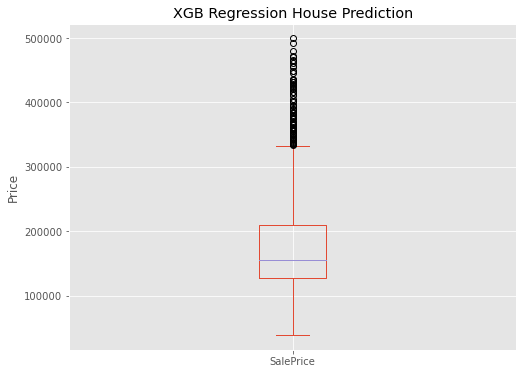

In [39]:
xgb_regression_fig = xgb_regression.plot(kind='box', figsize =(8,6))

plt.title('XGB Regression House Prediction')
plt.ylabel('Price')


In [40]:
xgb_regression.head()

,SalePrice
Id,
1461,123258.05
1462,161888.52
1463,178061.42
1464,189446.72
1465,185209.69


In [42]:
xgb_regression_fig.figure.savefig('XGB Regression House Prediction')

print('saved figure')

saved figure
